In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats #spearman rank correlation
import earthaccess



/Users/marietolteca/.conda/envs/arid_gw/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load in Data

In [15]:
# Load the ET R and Python Comparison CSV 
df = pd.read_csv('data/et_R_python_comparison.csv')

# View first five rows
df.head()

df[df['Site'] == 'Arizona (Willcox Basin)'].head()



,Site,Year,ET (R),ET (Python),Difference,Average Diff (Abs),Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,Arizona (Willcox Basin),2000.0,183.304348,206.75000,-23.445652,20.942761,NaN,NaN,NaN,NaN,NaN,NaN
1,Arizona (Willcox Basin),2001.0,246.591304,251.81001,-5.218706,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Arizona (Willcox Basin),2002.0,205.339130,224.33000,-18.990870,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Arizona (Willcox Basin),2003.0,210.904348,222.95000,-12.045652,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Arizona (Willcox Basin),2004.0,242.556522,265.68000,-23.123478,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Willcox GW ET 

In [21]:
# Reading in willcox csv
willcox_et = pd.read_csv('data/et_gw_merged_willcox.csv')

willcox_et.head()

,MEDS_ID,MEDS_ANNUAL_MEDIAN_ROW,YEAR,WaterLevel_m,WaterLevelElev_masl,Title Location,Lat,Lon,tile_id,year,location,latitude,longitude,tile,mean_ET_mm_yr,buffer_radius_m
0,8,319,2000,77.32776,NaN,Arizona (Willcox Basin),32.03619,-109.754,h08v05,2000.0,Arizona (Willcox Basin),32.03619,-109.754,h08v05,206.75000,1000.0
1,8,320,2003,83.05800,NaN,Arizona (Willcox Basin),32.03619,-109.754,h08v05,2003.0,Arizona (Willcox Basin),32.03619,-109.754,h08v05,222.95000,1000.0
2,8,321,2004,84.64296,NaN,Arizona (Willcox Basin),32.03619,-109.754,h08v05,2004.0,Arizona (Willcox Basin),32.03619,-109.754,h08v05,265.68000,1000.0
3,8,322,2005,88.20912,NaN,Arizona (Willcox Basin),32.03619,-109.754,h08v05,2005.0,Arizona (Willcox Basin),32.03619,-109.754,h08v05,264.49000,1000.0
4,8,323,2007,92.62872,NaN,Arizona (Willcox Basin),32.03619,-109.754,h08v05,2007.0,Arizona (Willcox Basin),32.03619,-109.754,h08v05,273.37997,1000.0


In [3]:
# Load Summary stats CSV
df_avg = pd.read_csv('data/et_R_python_min_max_diff.csv')

# View df
df_avg.head()

,Site,Avg Diff,Std,Min diff,Max diff
0,Arizona (Willcox Basin),20.94,23.57,3.06,43.86
1,Nevada (Amargosa),1.42,0.70,0.39,3.05
2,central Saudi Arabia (recovery near Al Kharj),0.00,0.00,0.00,0.00
3,Cuyama,5.00,4.75,0.05,3.05
4,MexicoAguascaliente,4.99,5.76,0.38,14.84


# Data Cleaning

In [34]:
# Removed any `unamed columns`
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# View first five rows
df.head()

#df[df['Site'] == 'Arizona (Willcox Basin)']


,Site,Year,ET (R),ET (Python),Difference,Average Diff (Abs)
0,Arizona (Willcox Basin),2000.0,183.304348,206.75000,-23.445652,20.942761
1,Arizona (Willcox Basin),2001.0,246.591304,251.81001,-5.218706,NaN
2,Arizona (Willcox Basin),2002.0,205.339130,224.33000,-18.990870,NaN
3,Arizona (Willcox Basin),2003.0,210.904348,222.95000,-12.045652,NaN
4,Arizona (Willcox Basin),2004.0,242.556522,265.68000,-23.123478,NaN


Arizona - Willcox Basin

In [ ]:
# Willcox - Rename YEAR to Year first
willcox_et = willcox_et.rename(columns={'YEAR': 'Year'})

# Inner Join
willcox_et = df.merge(willcox_et[['Year', 'WaterLevel_m']], 
                  on='Year', how='inner')

# View Results
willcox_et.head()

# Use Spearman Rank Correlation 

In [5]:
def spearman_by_site(df):
    """Calculate Spearman correlation between ET (R) and ET (Python) for each site."""
    # Create empty list
    results = []
    # Loop through unique sites
    for site in df['Site'].unique():
        # Filter data for current site
        site_data = df[df['Site'] == site]
        # Get ET columns and drop NA values
        clean_data = site_data[['ET (R)', 'ET (Python)']].dropna()
        # Need at least 2 points for correlation
        if len(clean_data) > 1:
            # Calculate Spearman correlation and p-value
            corr, pval = stats.spearmanr(clean_data['ET (R)'], clean_data['ET (Python)'])
            # Store results
            results.append({
                'Site': site,
                'n': len(clean_data),
                'Spearman_r': corr,
                'p_value': pval
            })
    # Return as DataFrame
    return pd.DataFrame(results)

In [6]:
# Run function
results = spearman_by_site(df)

# View Results
print(results)

                                            Site   n  Spearman_r       p_value
0                        Arizona (Willcox Basin)  23    0.692688  2.489667e-04
1                              Nevada (Amargosa)  23    0.999012  6.921818e-30
2  central Saudi Arabia (recovery near Al Kharj)  23    1.000000  0.000000e+00
3                                         Cuyama  23    0.975296  2.976291e-15
4                 Iran (north) West Qazvin Plain  23    0.988142  1.416100e-18
5                            MexicoAguascaliente  23    0.982213  9.745722e-17
6                                   TripoliLibya  23    0.985178  1.455572e-17


P-values are significant

### Arizona (Willcox Basin) 

In [30]:
# Spearman correlation-
corr, pval = stats.spearmanr(willcox_et['ET (Python)'], willcox_et['WaterLevel_m'])
print(f"The Spearman Rank Correlation for Willcox is: {corr:.4f} (p-value: {pval:.4e})")

The Spearman Rank Correlation for Willcox is: -0.0520 (p-value: 1.3477e-21)


# Scatterplot
Combined ET (R) and ET (Python) into one scatterplot. Points close to the 1:1 line indicate similar outputs between R and Python. Points far from the line indicate differences.

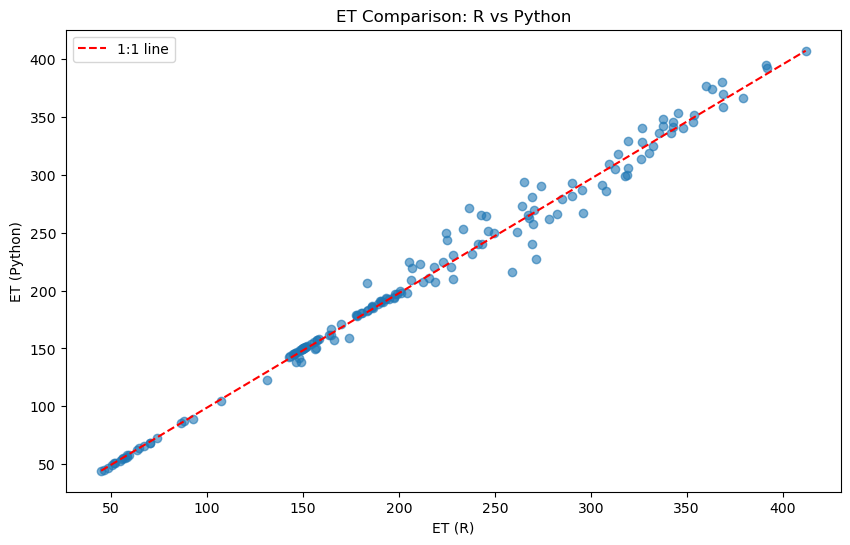

In [7]:
plt.figure(figsize=(10, 6))
plt.scatter(df['ET (R)'], df['ET (Python)'], alpha=0.6)
plt.plot([df['ET (R)'].min(), df['ET (R)'].max()], 
         [df['ET (Python)'].min(), df['ET (Python)'].max()], 
         'r--', label='1:1 line')
plt.xlabel('ET (R)')
plt.ylabel('ET (Python)')
plt.title('ET Comparison: R vs Python')
plt.legend()
plt.show()

# TimeSeries Visual

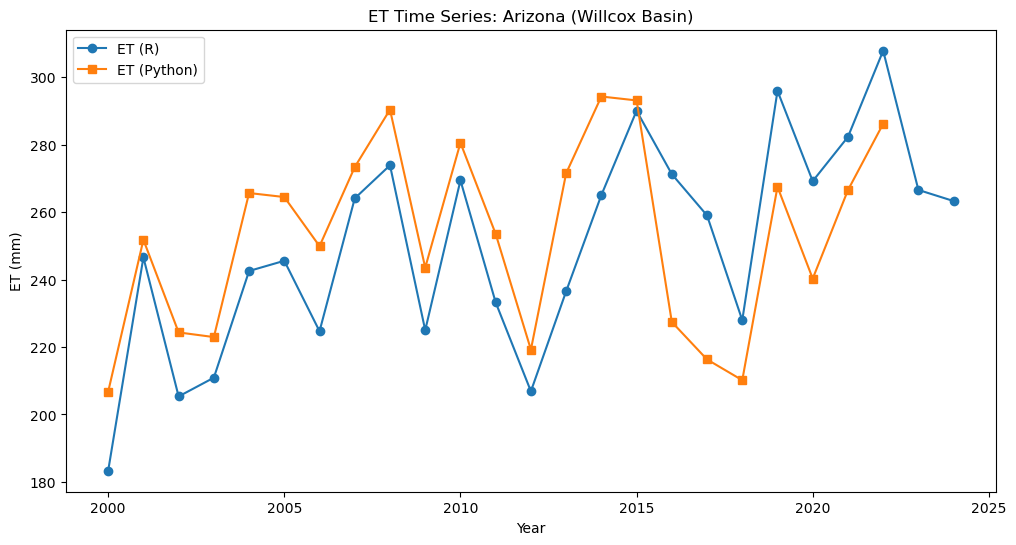

In [9]:
# For a specific site
site_name = 'Arizona (Willcox Basin)'
site_data = df[df['Site'] == site_name].sort_values('Year')

plt.figure(figsize=(12, 6))
plt.plot(site_data['Year'], site_data['ET (R)'], 'o-', label='ET (R)')
plt.plot(site_data['Year'], site_data['ET (Python)'], 's-', label='ET (Python)')
plt.xlabel('Year')
plt.ylabel('ET (mm)')
plt.title(f'ET Time Series: {site_name}')
plt.legend()
plt.show()

# Merging DF(Python and R ET) & Willcox

In [36]:
# Filter df for just Willcox
willcox_df = df[df['Site'] == 'Arizona (Willcox Basin)'].copy()

# Rename YEAR to Year in willcox_et
willcox_et = willcox_et.rename(columns={'YEAR': 'Year'})

# Merge
willcox_merged = willcox_df.merge(willcox_et[['Year', 'WaterLevel_m']], 
                                   on='Year', how='inner')

# Now use the function (even though it's just one site)
results = spearman_by_site(willcox_merged)
print(results)

# Or direct correlation
corr, pval = stats.spearmanr(willcox_merged['ET (Python)'], willcox_merged['WaterLevel_m'])
print(f"The Spearman Rank Correlation for Willcox is {corr:.4f} (p-value: {pval:.4e})")

                      Site      n  Spearman_r  p_value
0  Arizona (Willcox Basin)  33614    0.626374      0.0
The Spearman Rank Correlation for Willcox is 0.3846 (p-value: 0.0000e+00)


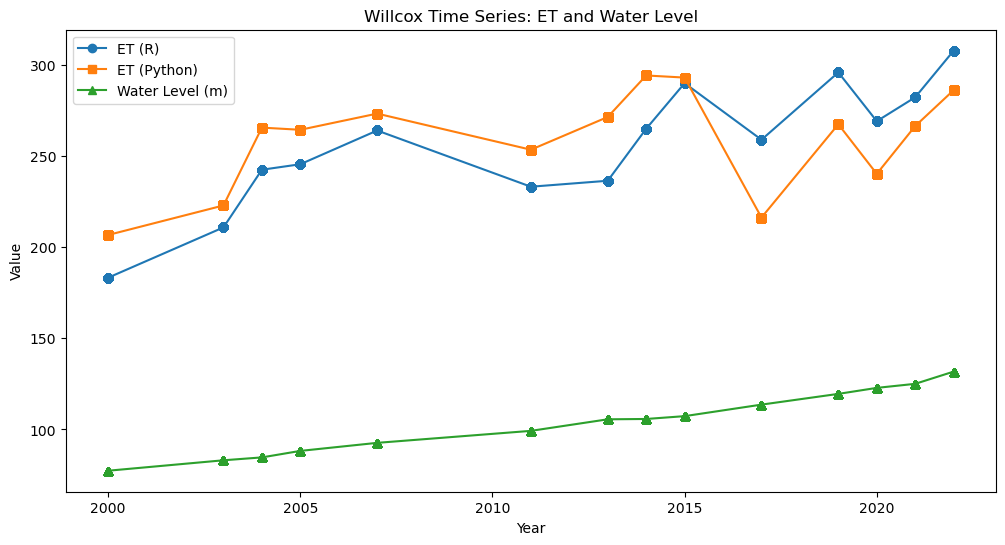

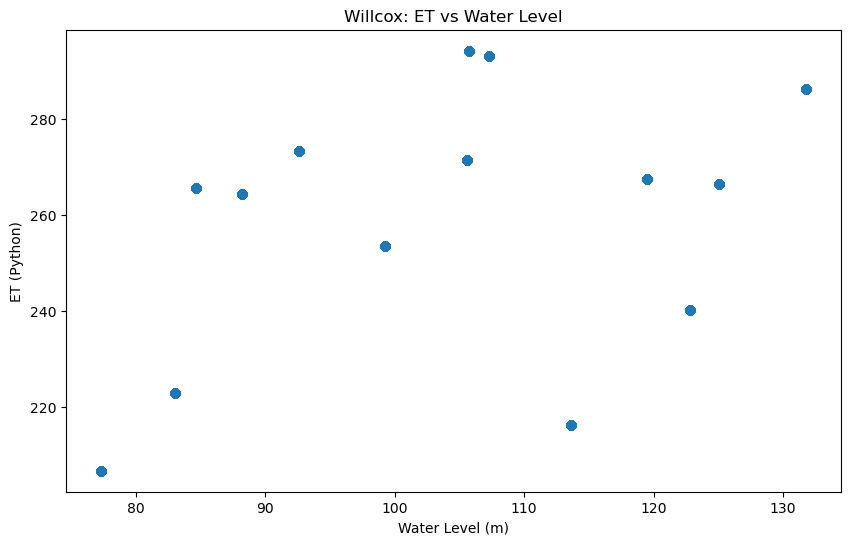

In [37]:
# Time series
plt.figure(figsize=(12, 6))
plt.plot(willcox_merged['Year'], willcox_merged['ET (R)'], 'o-', label='ET (R)')
plt.plot(willcox_merged['Year'], willcox_merged['ET (Python)'], 's-', label='ET (Python)')
plt.plot(willcox_merged['Year'], willcox_merged['WaterLevel_m'], '^-', label='Water Level (m)')
plt.xlabel('Year')
plt.ylabel('Value')
plt.title('Willcox Time Series: ET and Water Level')
plt.legend()
plt.show()

# Scatterplot - ET (Python) vs Water Level
plt.figure(figsize=(10, 6))
plt.scatter(willcox_merged['WaterLevel_m'], willcox_merged['ET (Python)'], alpha=0.6)
plt.xlabel('Water Level (m)')
plt.ylabel('ET (Python)')
plt.title('Willcox: ET vs Water Level')
plt.show()